# **Explainable Image Classification** 

Image Classification can be considered as the fundamental topic for computer vision. Deep learning that employs a layered neural network is applied to identify patterns in the images. In a nutshell, deep learning imitates the human logical reasoning process and learns continuously from data. The three types of layers such as input, hidden and output are used in deep learning. The data is received by the input layer, passed on to the hidden layers for processing and then the output layer generates the result. The layers are interconnected and depend on each other. The specific image classification algorithm that we are going to use here is Convolutional Neural Network (CNN). CNN combines the multilayer neural networks with specialized layers that are capable of extracting the features most important and relevant to the classification of an object.

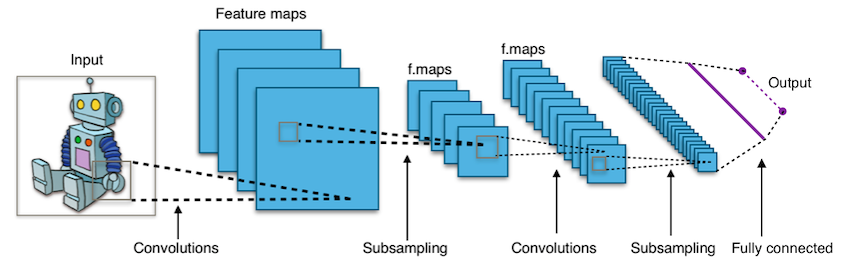

*Source: [Wikipedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)*

Although deep neural networks produce more accurate results than traditional ML in many cases, they are not easily explainable as simple models. Complex models like deep neural networks usually have millions of parameters and hundreds of layers that can be extremely difficult to interpret. This is why complex deep learning models are often called black boxes. So, without a clear understanding of how these models can predict the objects, many companies may not be willing to use deep learning especially in the critical decisions. 

Fortunately, there are some methods that can improve model interpretability. **SHAP** module is one of the most used ways of explaining the deep learning models. CNN can be explained by the scores on each pixel on a predicted image class to find out the pixel contributions to the probability either in positive or negative way. SHAP also provides both global and local explainability.

In this notebook, we are going to use a simple multiclass Image Classification problem to illustrate a Deep Learning explainability with SHAP Deep Explainer. The [Animal Image Dataset(Dog, Cat and Panda)](https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda) is used in this example. SHAP has already been successfully tried for some pre-trained models based on huge well-known datasets (millions of images). The idea in this tutorial is to test the SHAP Deep Explainer performance for a CNN pre-trained model in which only the final layer is trained based on 3 classes with a significantly small new dataset. 

#### This is the model architecture for this specific problem:

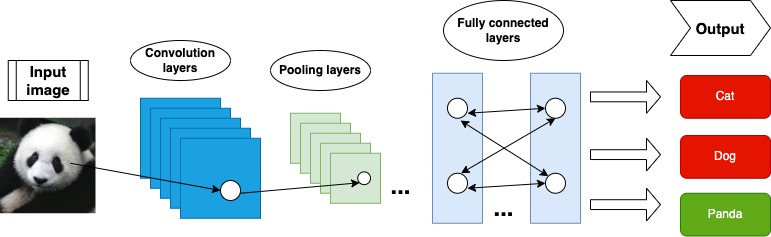

### **Environment and Data Preparation**

In [ ]:
!pip install torch
!pip install torchvision
!pip install shap
!pip install matplotlib

import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import shap

Although, this notebook supports both CPU and GPU, please run this notebook on GPU for the best practice.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

The Kaggle  dataset includes 1000 images for each of 3 classes (Cat, Dog and Panda). We have splitted our data folder into train and val subfolders and the split is 85%/15%.
First, we need to clone GitHub files to colab workspace and define some variables. 

In [ ]:
repo_name = "cv_aix360"
git_path = 'https://github.com/bkenan/cv_aix360.git'
!git clone "{git_path}"
data_dir = '/content/cv_aix360/data' # defining data directory
class_names = ['cat', 'dog', 'panda'] # defining class names
batch_size = 128 # defining the batch size
PATH = '/content/cv_aix360/model.pth' # defining the path for the model

Cloning into 'cv_aix360'...
remote: Enumerating objects: 3035, done.
remote: Counting objects: 100% (3035/3035), done.
remote: Compressing objects: 100% (3031/3031), done.
remote: Total 3035 (delta 8), reused 3027 (delta 3), pack-reused 0
Receiving objects: 100% (3035/3035), 227.19 MiB | 24.22 MiB/s, done.
Resolving deltas: 100% (8/8), done.


Next, we need to prepare data loaders for the modeling. We first set up transformations for training and validation sets. This includes resizing the images into 224 * 224 and normalization. We should then create datasets for training and validation sets in order to form our the data loaders for the modeling.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                          data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=2)

Visualization of the subset from the image training batch:

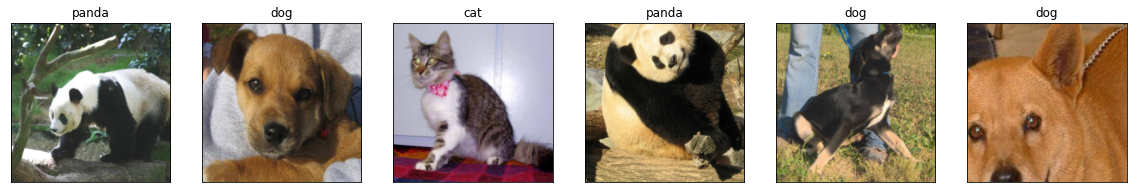

In [ ]:
images, labels = iter(train_loader).next()
images = images.numpy()
fig = plt.figure(figsize=(20, 16))
for idx in np.arange(6):
    ax = fig.add_subplot(1, 6, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

### **Modeling**

Note that, we've already trained the model with 98% of accuracy and saved it as 'model.pth' which was imported into the current working directory when we clonned the GitHub files to this colab workspace. We just need to load the model.

First, we are going to instantiate the pretrained ResNet-18 model for this purpose. This is a convolutional neural network that is 18 layers deep. We also need to shut off autograd for all layers to freeze the model so the layer weights are not trained until we load our trained model parameters for the final layer based on our 3 classes. 

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)

In [ ]:
# Loading the model
if device == torch.device("cuda"):
    model.load_state_dict(torch.load(PATH))
    model.to(device)
else:
    model.load_state_dict(torch.load(PATH, map_location=device))

Visualization of the batch of predictions along with true labels:

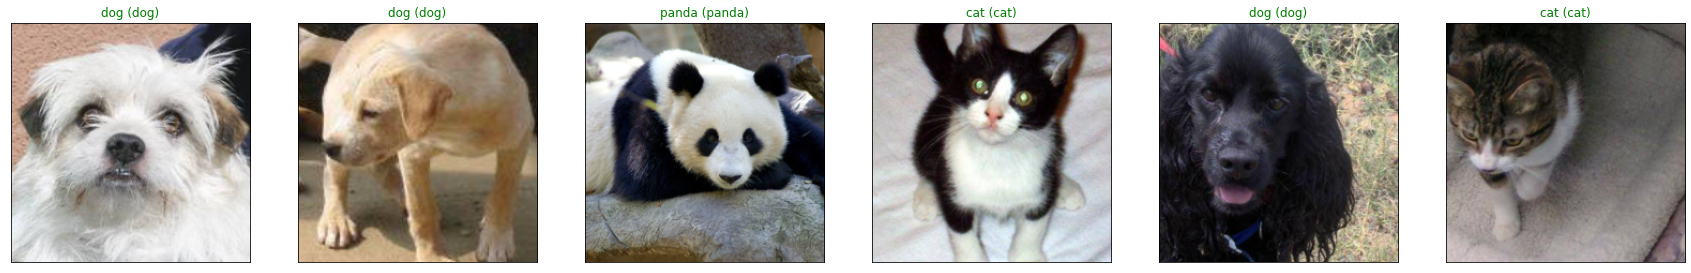

In [ ]:
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(val_loader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    fig = plt.figure(figsize=(30, 20))
    for idx in np.arange(6):
        ax = fig.add_subplot(1, 6, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(model,val_loader,device)

### **SHAP Deep Explainer**

We have to load some images for explainer before starting to use the SHAP module.

In [ ]:
batch = next(iter(val_loader))
images, _ = batch

We then define the background and test images for the Deep Explainer algorithm. Background images consist of 100 images, while the test images are next 5 images in the batch of 128 images.

In [ ]:
background = images[:100].to(device)
test_images = images[100:105].to(device)

We can now instantiate the SHAP Deep Explainer algorithm  based on the background images and the model we have. Also, for the sake of plotting, we are going to turn the results into the numpy arrays.

In [ ]:
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Alright! Our Deep Explainer output is available and we can now plot the results! The rows represent the test images, while the columns represent the true values. The key lessons here:

1.   **Red** pixels demonstrate positive SHAP values meaning that these pixels contributed to classifying an image to a particular class. 
2.   **Blue** pixels demonstrate negative SHAP values that contributed to **not** classifying an image to a particular class.

As we can observe here based on the test images, the Deep Explainer has focused on the face, especially the eyes and nose while differentiating these 3 animals. The algorithm highlighted the pixels as red from the mentioned parts of the animals, meaning that these differentiating factors played the most important role in deciding the classification of the images in this example. Also, the algorithm highlighted almost the same pixels as blue for the classes that the model found irrelevant.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


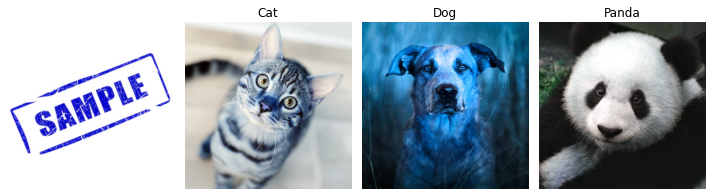

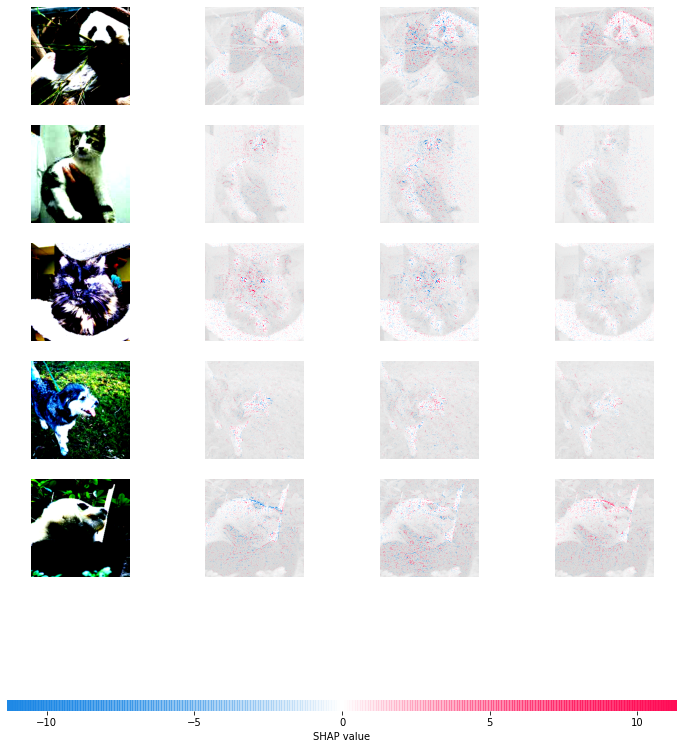

In [ ]:
# create figure
fig = plt.figure(figsize=(10, 6))

# setting values to rows and column variables
rows = 1
columns = 4

# reading images
Image1 = cv2.imread('/content/cv_aix360/data/classes/sample.jpg')
Image2 = cv2.imread('/content/cv_aix360/data/classes/cat.jpg')
Image3 = cv2.imread('/content/cv_aix360/data/classes/dog.jpg')
Image4 = cv2.imread('/content/cv_aix360/data/classes/panda.jpg')

# Adds a subplot at the 1st position
fig.tight_layout()
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(Image1)
plt.axis('off')

# Adds a subplot at the 2nd position
fig.tight_layout()
fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(Image2)
plt.axis('off')
plt.title("Cat")

# Adds a subplot at the 3rd position
fig.tight_layout()
fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(Image3)
plt.axis('off')
plt.title("Dog")

# Adds a subplot at the 3rd position
fig.tight_layout()
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(Image4)
plt.axis('off')
plt.title("Panda")


shap.image_plot(shap_numpy, test_numpy * 255)